# Load model, data

In [1]:
# load a trained model
import keras
import crested

model_path = "//allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/human/finetune/12.keras"
model = keras.models.load_model(model_path, compile=False)  # change to your model path

2025-08-08 11:43:25.160340: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 11:43:25.184481: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-08 11:43:25.391017: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-08 11:43:25.599296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754678605.767911  626208 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754678605.82

In [2]:
import anndata as ad
adata= ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/crested_adata/human_basalganglia_hmba_pre-print_crested.h5ad")


In [3]:
adata.shape

(59, 1360262)

In [4]:
import os

genome_fasta  = "/allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa"

# if you ever need a .chrom.sizes (for change_regions_width etc)
chr_sizes     = os.path.abspath(
    os.path.join(os.path.dirname(genome_fasta), "../star/chrNameLength.txt")
)

genome = crested.Genome(
   genome_fasta, chr_sizes)

crested.register_genome(
    genome
)  # Register the genome so that it can be used by the package

print(genome.fetch("chr1", 10000, 10010))

2025-08-08T11:43:48.614805-0700 INFO Genome genome registered.
TAACCCTAAC


## Do predictions on (entire) set

We take the entire set so we make sure to not leave any cell type specific regions.

In [5]:
# store predictions for all our regions in the anndata object for later inspection.
import pysam
from tqdm import tqdm
fasta = pysam.FastaFile(genome_fasta)

seqs = [
    fasta.fetch(chrom, start, end)
    for chrom, start, end in tqdm(zip(adata.var['chr'], adata.var['start'], adata.var['end']))
]


predictions = crested.tl.predict(seqs, model, verbose=2)
adata.layers["finetuned"] =predictions.T  # adata expects (C, N) instead of (N, C)

1360262it [00:13, 102130.41it/s]
I0000 00:00:1754592408.684955  583464 service.cc:148] XLA service 0x7f5d38002430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754592408.684986  583464 service.cc:156]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2025-08-07 11:46:48.710998: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754592408.797886  583464 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-08-07 11:46:49.749532: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_369', 280 bytes spill stores, 280 bytes spill loads

2025-08-07 11:46:49.845731: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 

10628/10628 - 689s - 65ms/step


# Make the filtered anndata on top peaks

In [6]:
adata_combined = adata.copy()  # Copy the peak heights
adata_combined.X = (
    adata_combined.X + adata_combined.layers["finetuned"]
) / 2  # Take the average with the predictions

In [7]:
# most informative regions per class
adata_filtered = adata_combined.copy()
top_k = 500  
crested.pp.sort_and_filter_regions_on_specificity(
    adata_filtered, top_k=top_k, method="proportion"
)
adata_filtered

2025-08-07T11:58:25.585792-0700 INFO After sorting and filtering, kept 29500 regions.


/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 59 × 29500
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'split', 'Class name', 'rank', 'proportion_score'
    obsm: 'weights'
    layers: 'finetuned'

## Look at some example regions

chr                      chr6
start               127673994
end                 127676108
split                   train
Class name          OT_D1_ICj
rank                      301
proportion_score     0.157851
Name: chr6:127673994-127676108, dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


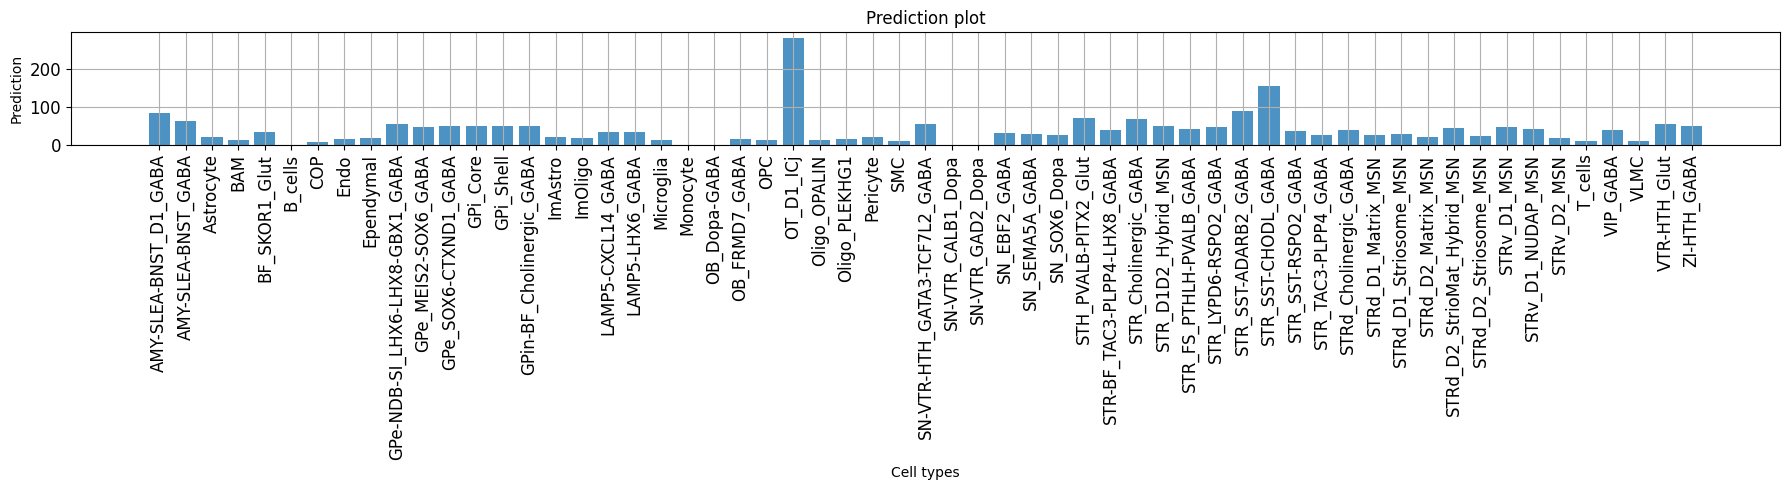

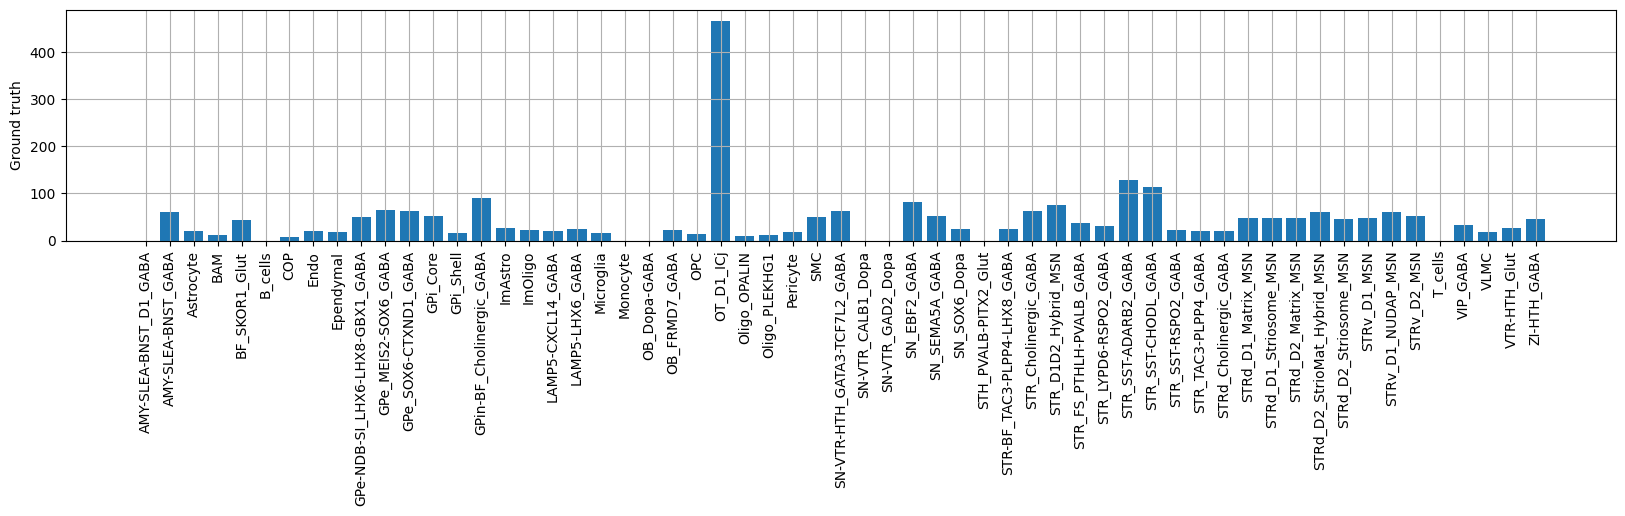

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
idx = 12300
reg = adata_filtered.var.iloc[idx]
print(reg)
chrom = reg['chr']
start = reg['start']
end = start+2114
seq_id = chrom+':'+str(start)+'-'+str(end)
sequence = genome.fetch(chrom, start, end)
prediction = crested.tl.predict(sequence, model)
crested.pl.bar.prediction(prediction, classes=list(adata.obs_names), x_label_rotation=90, height=5)
name = adata_filtered.var.index[idx]
reg_idx = adata.var_names.get_loc(name)
plt.figure(figsize=(20,3))
plt.bar(adata.obs_names, adata.X.T[reg_idx])
plt.xticks(rotation=90)
plt.ylabel('Ground truth')
plt.grid('on')

In [19]:
import numpy as np
cl_idx = int(np.argmax(prediction))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=cl_idx,  # None (=all classes), list of target indices, or empty list (='combined' class)
    model=model,
    method="integrated_grad",  # default. Other options: "integrated_grad", "mutagenesis"
)

2025-08-07T12:00:11.871328-0700 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


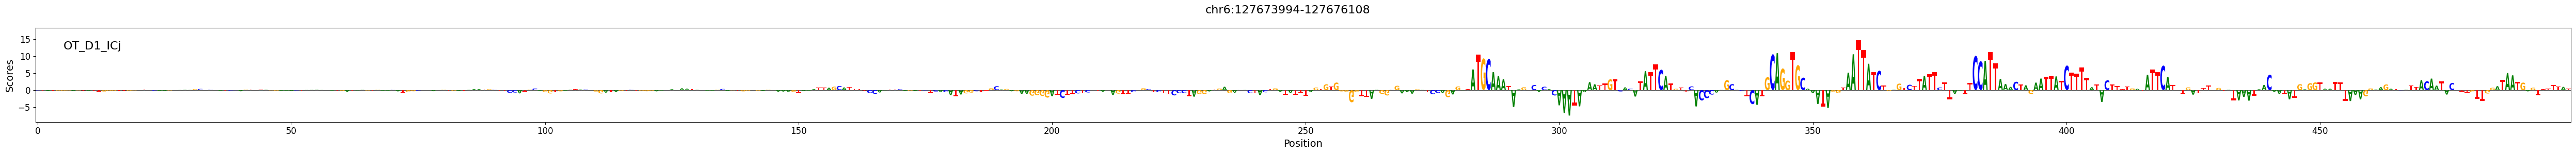

In [20]:
%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[""],
    class_labels=[list(adata.obs_names)[cl_idx]],
    zoom_n_bases=500,
    title=seq_id,
    height=3
)  # zoom in on the center 500bp

# Calculate contribution scores and patterns per cell type

In [21]:
crested.tl.contribution_scores_specific(
    input=adata_filtered,
    target_idx=None,  # We calculate for all classes
    model=model,
    method='integrated_grad',
    output_dir="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/modisco_results_ft_500/",
    verbose=True
)

2025-08-07T12:00:25.711264-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.98s/it]


2025-08-07T12:01:18.352983-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.97s/it]


2025-08-07T12:02:10.845536-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.85s/it]


2025-08-07T12:03:03.132972-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.09s/it]


2025-08-07T12:03:55.796108-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.08s/it]


2025-08-07T12:04:48.180480-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.01s/it]


2025-08-07T12:05:40.376688-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.46s/it]


2025-08-07T12:06:33.239306-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:48<00:00, 48.65s/it]


2025-08-07T12:07:27.413954-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.70s/it]


2025-08-07T12:08:20.442477-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.76s/it]


2025-08-07T12:09:13.661802-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.83s/it]


2025-08-07T12:10:06.922530-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.78s/it]


2025-08-07T12:11:00.152180-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.58s/it]


2025-08-07T12:11:53.199764-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.94s/it]


2025-08-07T12:12:45.703269-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.11s/it]


2025-08-07T12:13:38.274687-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.15s/it]


2025-08-07T12:14:30.979894-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.17s/it]


2025-08-07T12:15:23.624707-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.20s/it]


2025-08-07T12:16:16.409877-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.14s/it]


2025-08-07T12:17:09.090956-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:48<00:00, 48.04s/it]


2025-08-07T12:18:02.659373-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.10s/it]


2025-08-07T12:18:55.289279-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.98s/it]


2025-08-07T12:19:47.639321-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.14s/it]


2025-08-07T12:20:40.153338-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.43s/it]


2025-08-07T12:21:33.014487-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.82s/it]


2025-08-07T12:22:26.365301-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.79s/it]


2025-08-07T12:23:19.606676-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.81s/it]


2025-08-07T12:24:12.845612-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.69s/it]


2025-08-07T12:25:05.977695-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.83s/it]


2025-08-07T12:25:59.347870-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.79s/it]


2025-08-07T12:26:52.579936-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.80s/it]


2025-08-07T12:27:45.266047-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.84s/it]


2025-08-07T12:28:37.728554-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:48<00:00, 48.50s/it]


2025-08-07T12:29:31.748513-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.88s/it]


2025-08-07T12:30:25.202580-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.98s/it]


2025-08-07T12:31:17.745920-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.81s/it]


2025-08-07T12:32:10.038953-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.88s/it]


2025-08-07T12:33:02.442585-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.99s/it]


2025-08-07T12:33:54.852068-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.80s/it]


2025-08-07T12:34:48.305455-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.90s/it]


2025-08-07T12:35:41.693818-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.88s/it]


2025-08-07T12:36:35.136040-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.70s/it]


2025-08-07T12:37:28.313472-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.44s/it]


2025-08-07T12:38:21.054167-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.34s/it]


2025-08-07T12:39:13.888851-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:48<00:00, 48.09s/it]


2025-08-07T12:40:07.500229-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.27s/it]


2025-08-07T12:41:00.151594-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.48s/it]


2025-08-07T12:41:52.238658-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.20s/it]


2025-08-07T12:42:45.056862-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.73s/it]


2025-08-07T12:43:37.410377-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.53s/it]


2025-08-07T12:44:29.501997-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.42s/it]


2025-08-07T12:45:21.544685-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.77s/it]


2025-08-07T12:46:13.991697-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.82s/it]


2025-08-07T12:47:06.445321-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.62s/it]


2025-08-07T12:47:58.678618-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.54s/it]


2025-08-07T12:48:50.838439-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.76s/it]


2025-08-07T12:49:43.084561-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.72s/it]


2025-08-07T12:50:35.192633-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:47<00:00, 47.47s/it]


2025-08-07T12:51:28.110489-0700 INFO Calculating contribution scores for 1 class(es) and 500 region(s).


Model: 100%|██████████| 1/1 [00:46<00:00, 46.76s/it]


(array([[[[-1.50880824e-05, -5.83763067e-05,  1.10724031e-04, ...,
            1.76500384e-04,  2.20726739e-04,  5.49221404e-05],
          [ 4.76753812e-05,  9.56800523e-06, -5.23252493e-05, ...,
            1.70150874e-04, -8.26428368e-05,  3.77680517e-05],
          [-7.81450672e-06, -2.62029698e-05,  5.76178536e-05, ...,
           -8.76925624e-05,  1.99254573e-04, -1.77969632e-05],
          [-1.00250304e-06,  9.26661232e-05, -1.04822611e-05, ...,
           -7.81987110e-05, -1.50701395e-04, -2.85790338e-06]]],
 
 
        [[[-2.17340275e-05, -1.33763833e-05,  3.12728807e-05, ...,
           -2.94900401e-05, -9.53428535e-05,  2.71314530e-05],
          [-7.73190732e-06, -4.68514627e-05, -2.74188151e-05, ...,
            2.89880463e-05,  5.81708955e-05, -2.75295024e-05],
          [ 1.33265553e-06,  2.19336594e-04,  7.11291359e-05, ...,
           -1.96588167e-04, -3.89589659e-05, -2.92427685e-05],
          [ 2.22283725e-05, -1.01077429e-04,  5.17439548e-05, ...,
            3.672

In [1]:
import crested
meme_db, motif_to_tf_file = crested.get_motif_db()

2025-08-07 15:50:07.353009: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-07 15:50:07.369304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754607007.388217  612613 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754607007.393932  612613 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-07 15:50:07.412414: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import os
os.environ["PATH"] = "/home/niklas.kempynck/meme/bin:" + os.environ["PATH"]

In [ ]:
# run tfmodisco on the contribution scores
crested.tl.modisco.tfmodisco(
    window=1000,
    output_dir="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/modisco_results_ft_500/",
    contrib_dir="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/modisco_results_ft_500/",
    #report=True,  # Optional, will match patterns to motif MEME database
    #meme_db=meme_db,  # File to MEME database
    max_seqlets=20000,
)

2025-08-07T15:51:37.819472-0700 INFO No class names provided, using all found in the contribution directory: ['STRv_D1_NUDAP_MSN', 'STRd_D1_Striosome_MSN', 'GPin-BF_Cholinergic_GABA', 'OT_D1_ICj', 'STR_SST-ADARB2_GABA', 'ImAstro', 'SN-VTR_GAD2_Dopa', 'STR_SST-CHODL_GABA', 'BF_SKOR1_Glut', 'STRd_D1_Matrix_MSN', 'STR_D1D2_Hybrid_MSN', 'VTR-HTH_Glut', 'STH_PVALB-PITX2_Glut', 'SN_EBF2_GABA', 'SN_SEMA5A_GABA', 'SMC', 'VIP_GABA', 'STR-BF_TAC3-PLPP4-LHX8_GABA', 'ZI-HTH_GABA', 'BAM', 'Astrocyte', 'STRd_D2_Striosome_MSN', 'SN-VTR-HTH_GATA3-TCF7L2_GABA', 'OB_Dopa-GABA', 'STR_TAC3-PLPP4_GABA', 'LAMP5-LHX6_GABA', 'Ependymal', 'Microglia', 'OPC', 'VLMC', 'STRv_D1_MSN', 'GPe-NDB-SI_LHX6-LHX8-GBX1_GABA', 'OB_FRMD7_GABA', 'STRv_D2_MSN', 'Oligo_PLEKHG1', 'GPi_Core', 'STR_FS_PTHLH-PVALB_GABA', 'SN-VTR_CALB1_Dopa', 'STRd_D2_StrioMat_Hybrid_MSN', 'SN_SOX6_Dopa', 'GPe_SOX6-CTXND1_GABA', 'STRd_D2_Matrix_MSN', 'LAMP5-CXCL14_GABA', 'STR_Cholinergic_GABA', 'STR_LYPD6-RSPO2_GABA', 'GPi_Shell', 'T_cells', 'Endo'

# Pattern analysis

In [5]:
# First we obtain the resulting modisco files per class
matched_files = crested.tl.modisco.match_h5_files_to_classes(
    contribution_dir="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/modisco_results_ft_500/", classes=list(adata.obs_names)
)

In [6]:
sim_matrix, pattern_ids, pattern_dict = crested.tl.modisco.calculate_tomtom_similarity_per_pattern(
    matched_files = matched_files,
    trim_ic_threshold=0.025,
    verbose=True
)

Reading file /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/modisco_results_ft_500/AMY-SLEA-BNST_D1_GABA_modisco_results.h5
Reading file /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/modisco_results_ft_500/AMY-SLEA-BNST_GABA_modisco_results.h5
Reading file /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/modisco_results_ft_500/Astrocyte_modisco_results.h5
Reading file /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/modisco_results_ft_500/BAM_modisco_results.h5
Reading file /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/modisco_results_ft_500/BF_SKOR1_Glut_modisco_results.h5
Reading file /allen/programs/celltyp

In [7]:
import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex

groups = []
for id in pattern_ids:
    ct = '_'.join(id.split('_')[:-3])
    groups.append(ct)

unique_cats = pd.unique(groups)
group_colors = {cat: to_hex(get_cmap("tab20", len(unique_cats))(i)) for i, cat in enumerate(unique_cats)}

/home/niklas.kempynck/wandb_tmp/ipykernel_771720/3291599918.py:10: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_cats = pd.unique(groups)
/home/niklas.kempynck/wandb_tmp/ipykernel_771720/3291599918.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  group_colors = {cat: to_hex(get_cmap("tab20", len(unique_cats))(i)) for i, cat in enumerate(unique_cats)}


/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


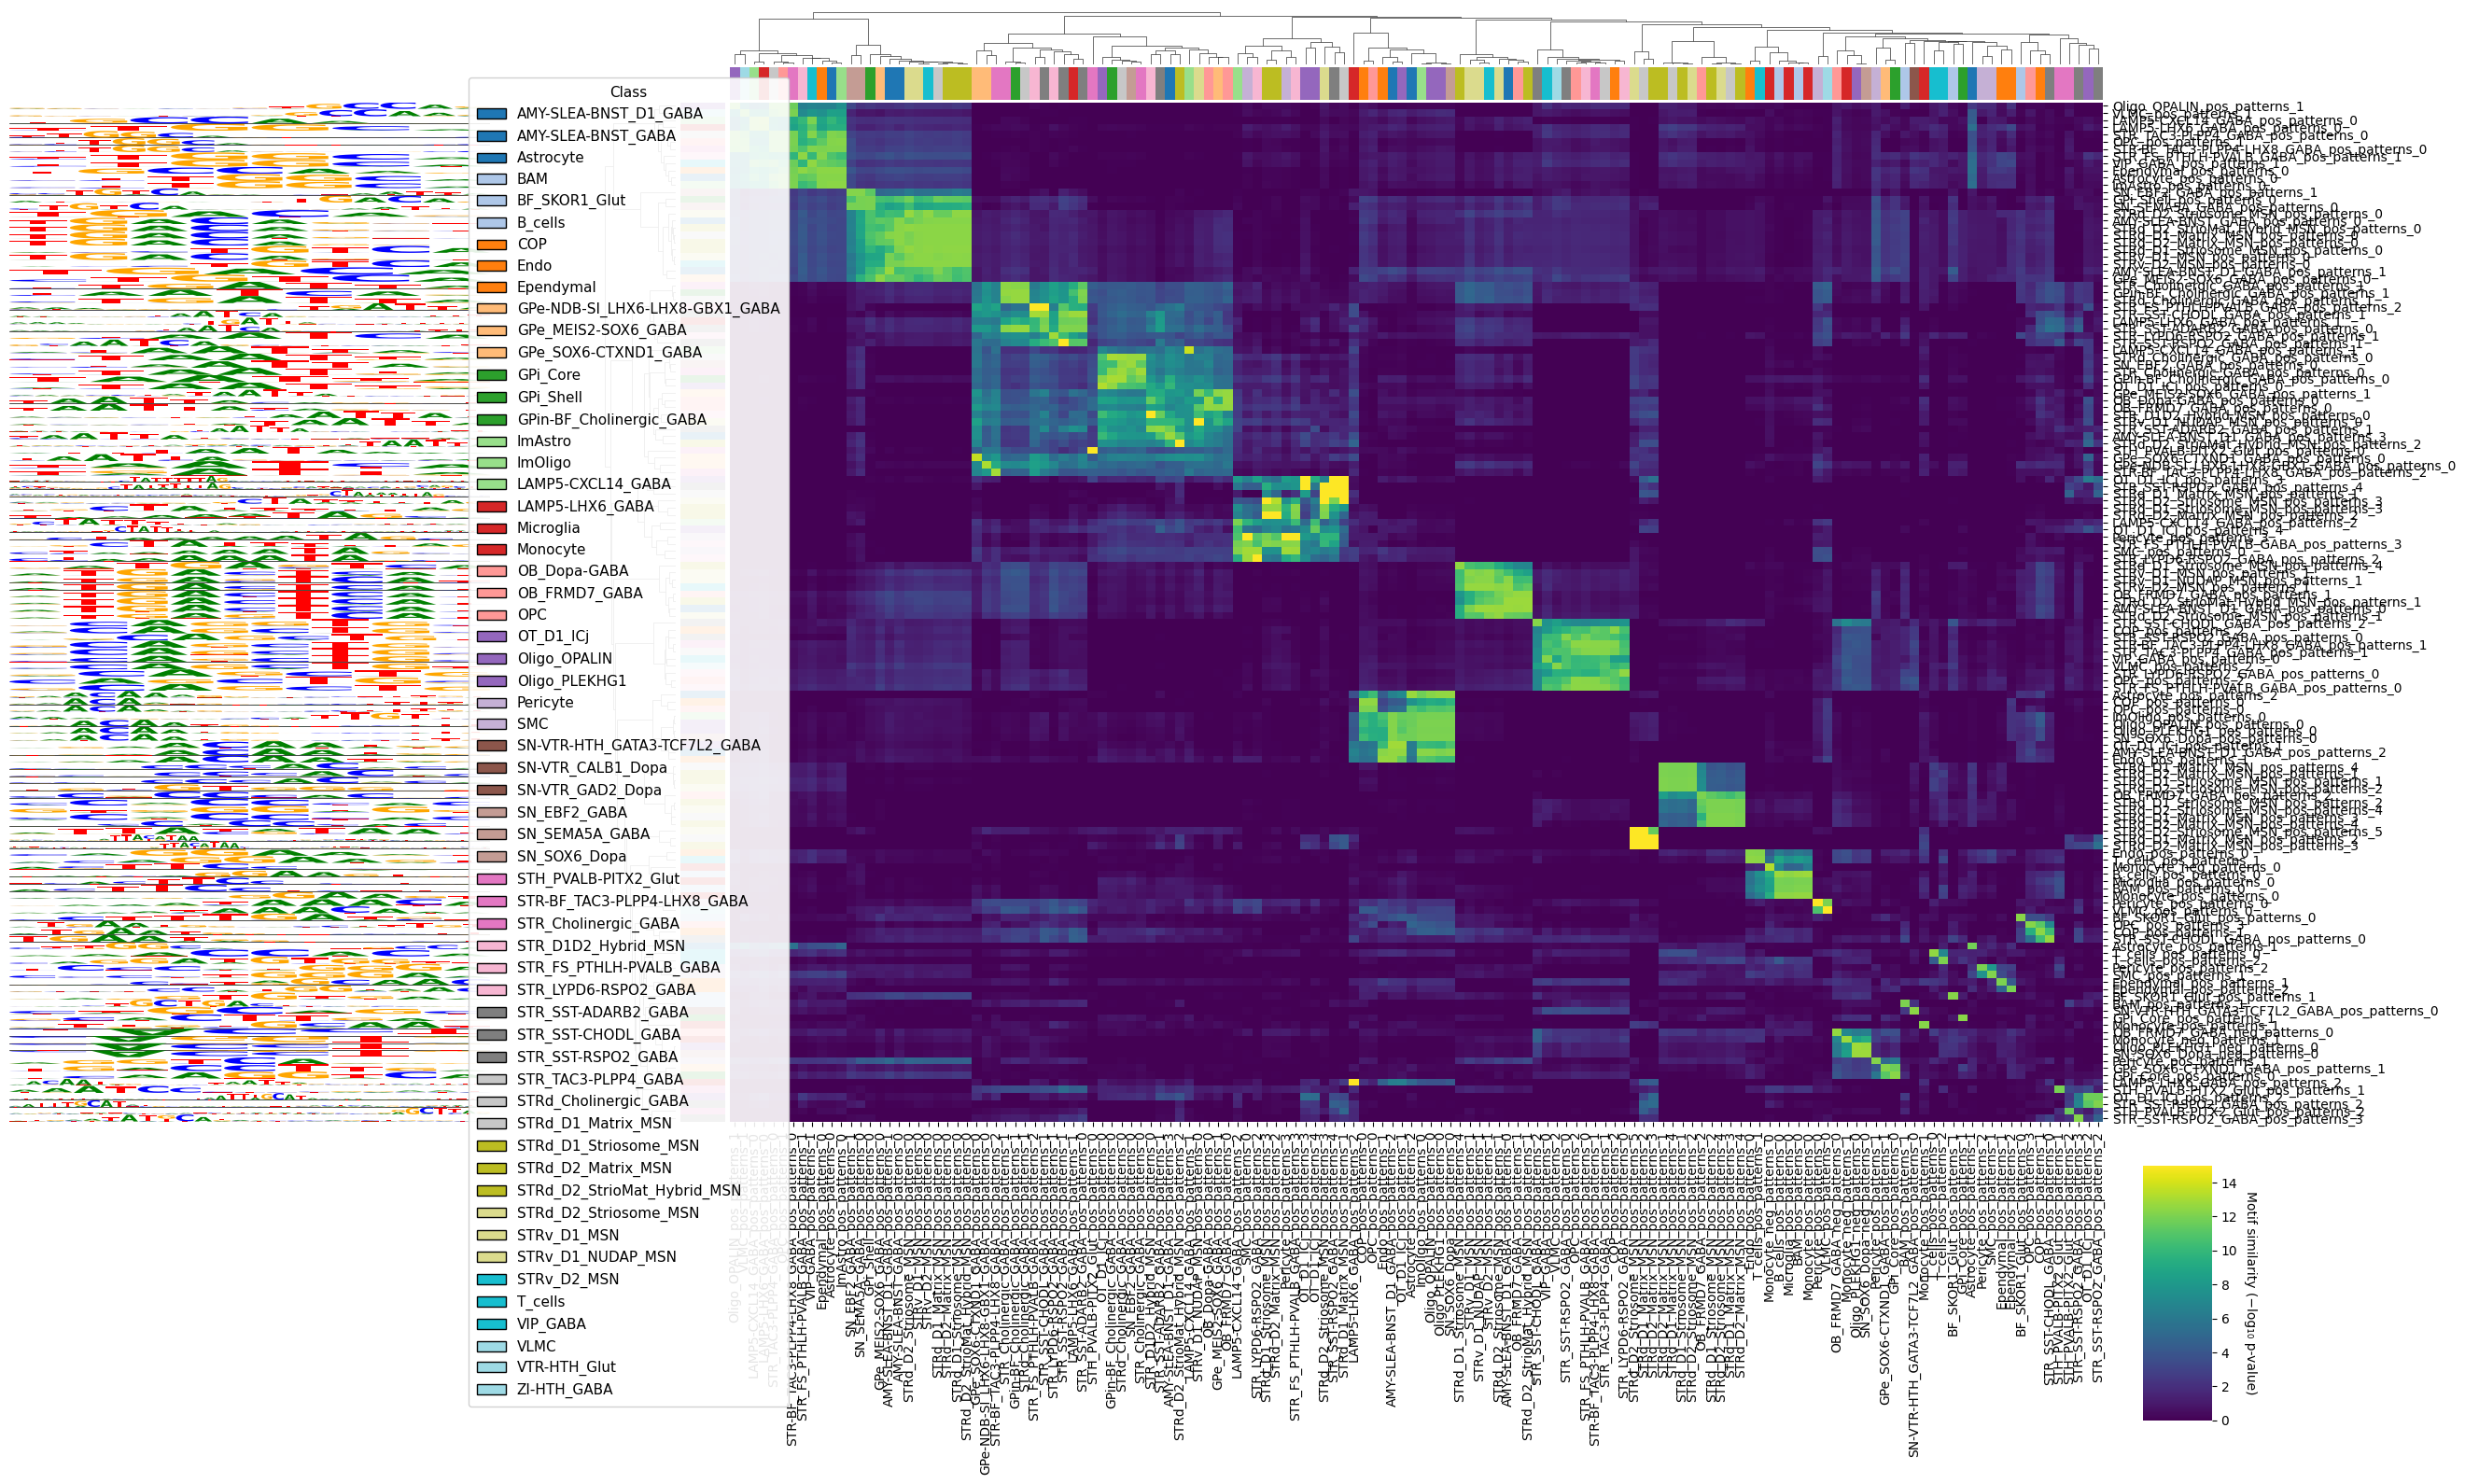

In [8]:
%matplotlib inline
crested.pl.patterns.clustermap_tomtom_similarities(
    sim_matrix=sim_matrix,
    ids=pattern_ids,
    pattern_dict=pattern_dict,
    group_info = [(groups, group_colors)], # Grouping labels
    min_seqlets=200, # Add a minimum amount of seqlets to take the most relevant patterns
    figsize=(16,16)
)

In [9]:
# Then we cluster matching patterns, and define a pattern matrix [#classes, #patterns] describing their importance
all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=7,  # The similarity threshold used for matching patterns. We take the -log10(pval), pval obtained through TOMTOM matching from memesuite-lite
    trim_ic_threshold=0.025,  # Information content (IC) threshold on which to trim patterns
    discard_ic_threshold=0.2,  # IC threshold used for discarding single instance patterns
    verbose=True,  # Useful for doing sanity checks on matching patterns
)

Reading file /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/modisco_results_ft_500/AMY-SLEA-BNST_D1_GABA_modisco_results.h5
Match between AMY-SLEA-BNST_D1_GABA_pos_patterns_11 and AMY-SLEA-BNST_D1_GABA_pos_patterns_9 with similarity score 7.84
Reading file /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/modisco_results_ft_500/AMY-SLEA-BNST_GABA_modisco_results.h5
Match between AMY-SLEA-BNST_GABA_pos_patterns_0 and AMY-SLEA-BNST_D1_GABA_pos_patterns_1 with similarity score 9.81
Match between AMY-SLEA-BNST_GABA_pos_patterns_3 and AMY-SLEA-BNST_D1_GABA_pos_patterns_9 with similarity score 11.48
Match between AMY-SLEA-BNST_GABA_pos_patterns_5 and AMY-SLEA-BNST_D1_GABA_pos_patterns_7 with similarity score 10.58
Match between AMY-SLEA-BNST_GABA_pos_patterns_14 and AMY-SLEA-BNST_GABA_pos_patterns_10 with similarity score 9.12
Match between AM

In [11]:
import pickle
with open("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/patterns_updated.pkl", "wb") as f:
    pickle.dump(all_patterns, f)

In [7]:
import pickle
with open("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/patterns_updated.pkl", "rb") as f:
    all_patterns = pickle.load(f)

In [8]:
pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(adata.obs_names),
    all_patterns=all_patterns,
    normalize=False,
    pattern_parameter="seqlet_count_log",
)
pattern_matrix.shape

(59, 166)

In [9]:
import numpy as np
np.exp(4.5)

np.float64(90.01713130052181)

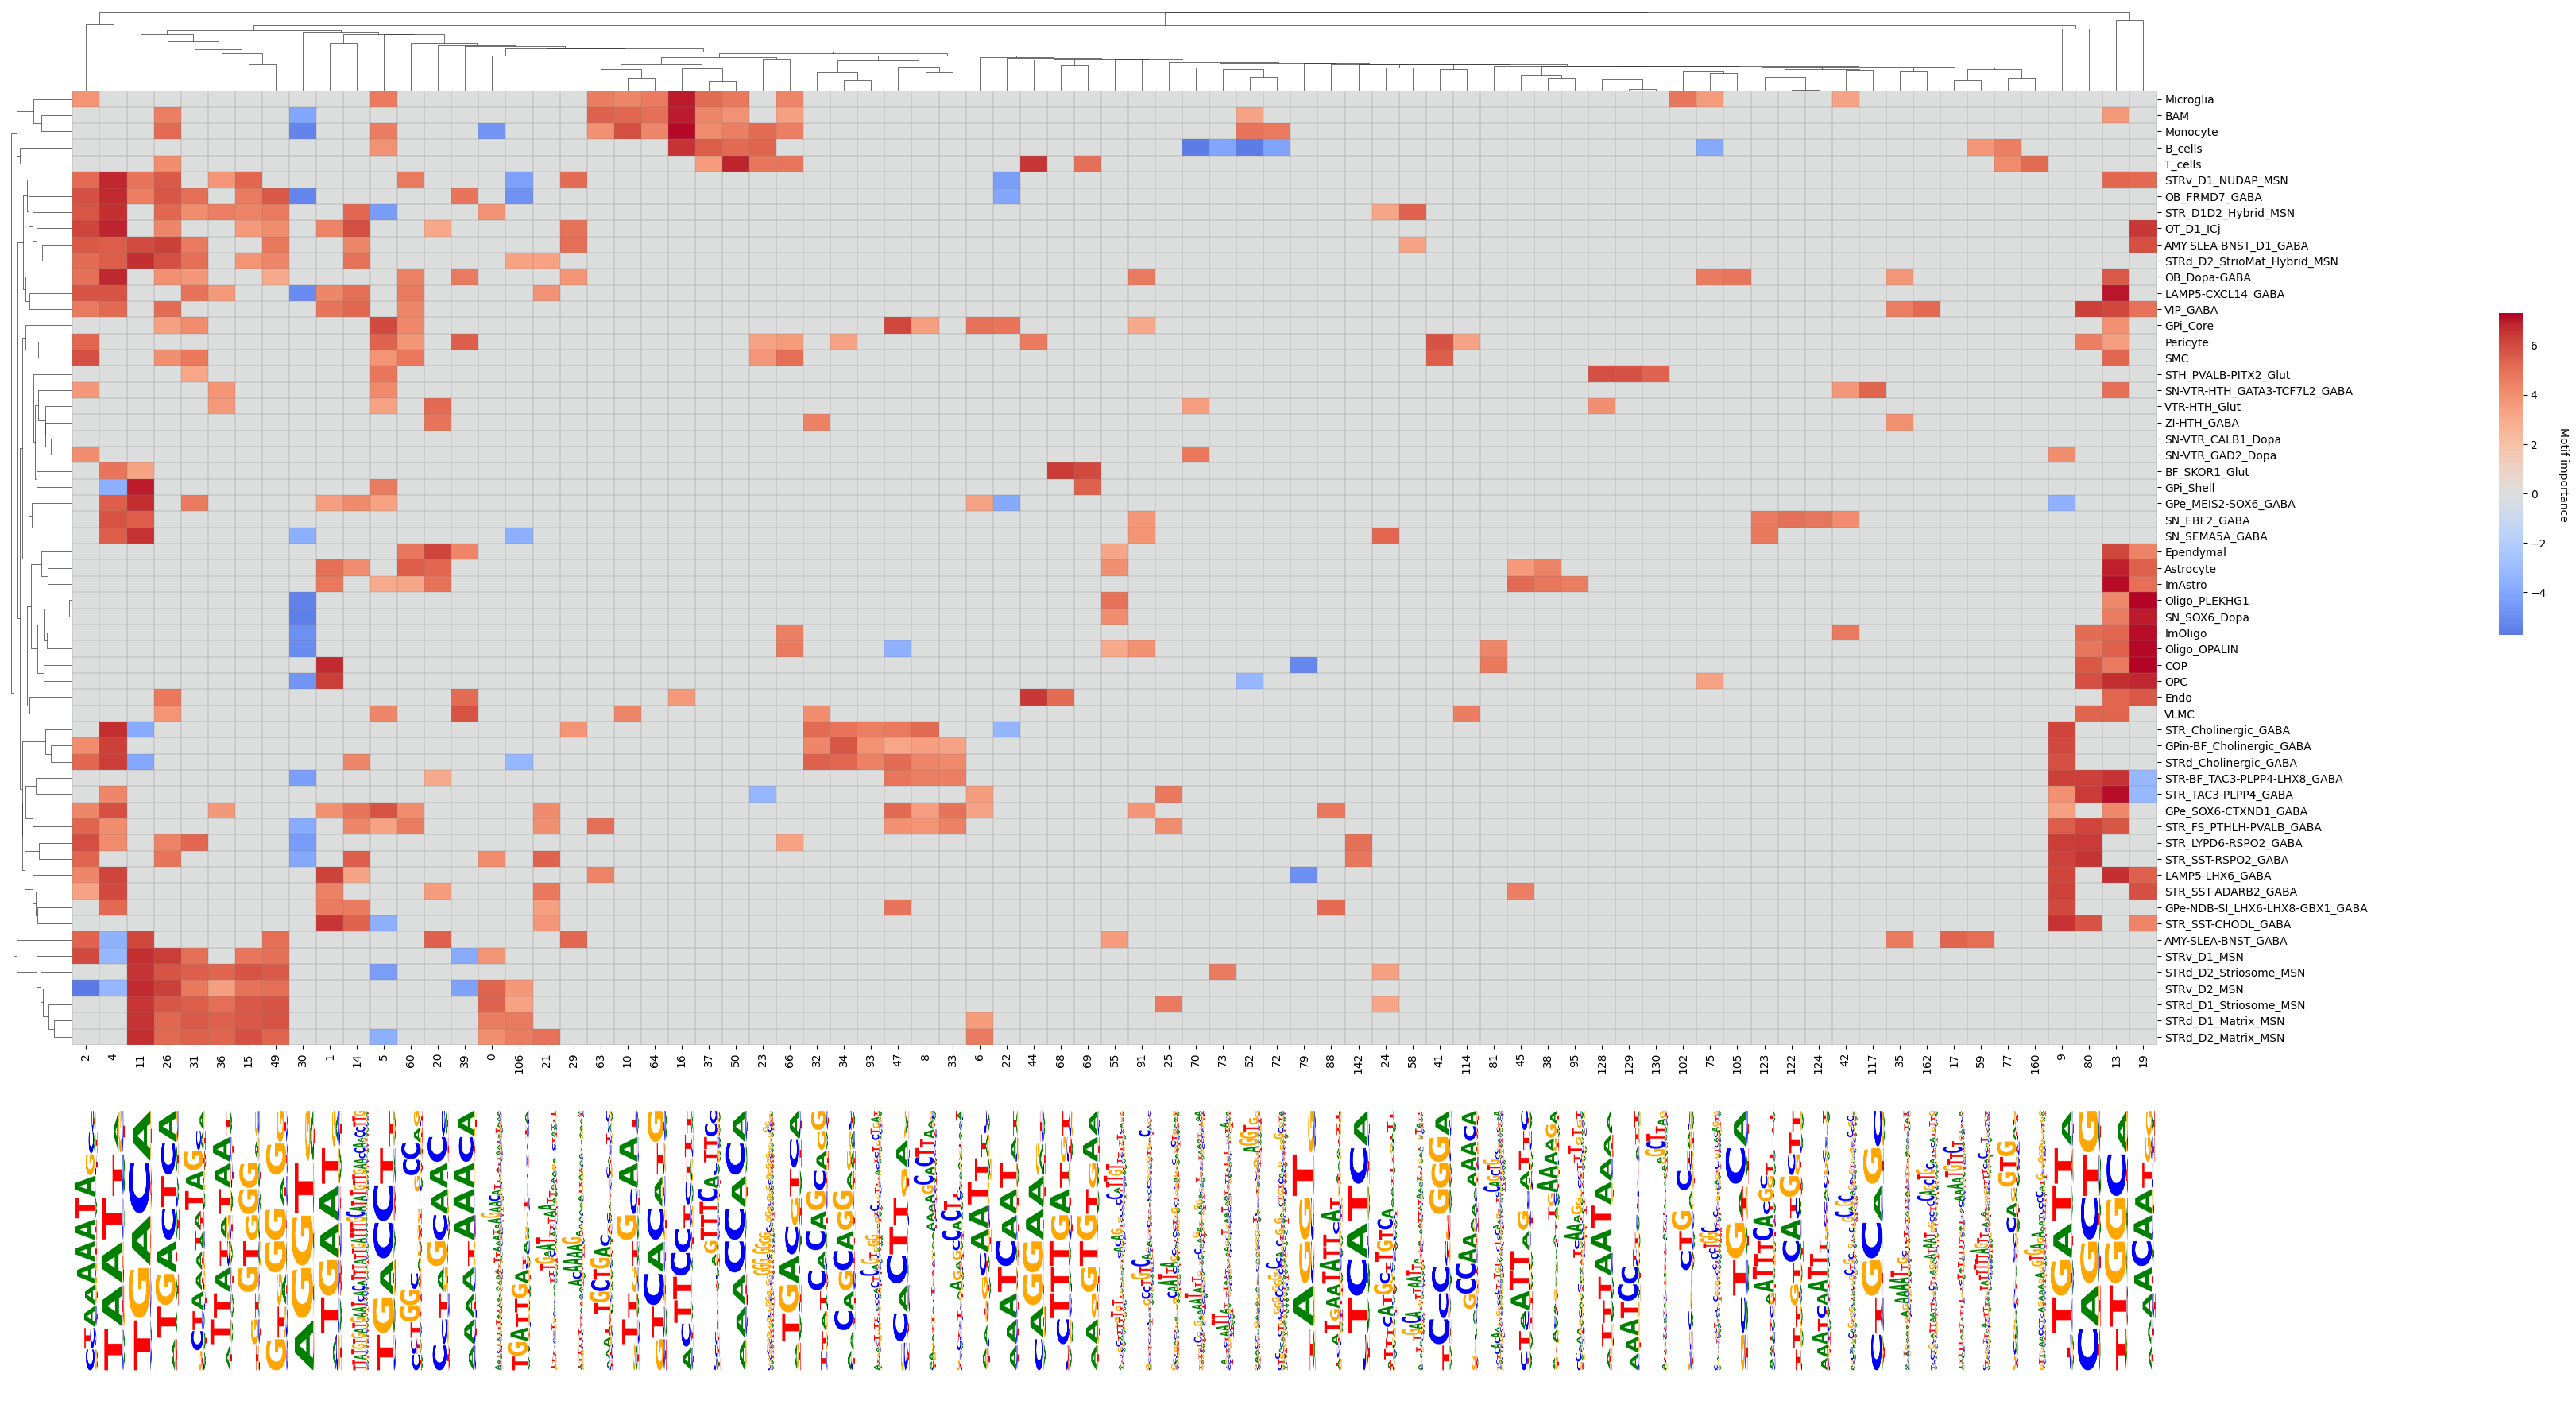

In [10]:
%matplotlib inline
crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix,
    list(adata.obs_names),
    pattern_dict=all_patterns,
    figsize=(30, 10),
    grid=True,
    dendrogram_ratio=(0.03, 0.08),
    importance_threshold=4.5,  # 3.5,
    logo_height_fraction=0.35,
    logo_y_padding=0.1,
)

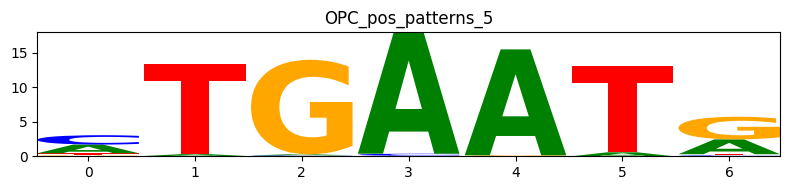

In [11]:
pattern_indices = [1]
crested.pl.patterns.selected_instances(
    all_patterns, pattern_indices
) 

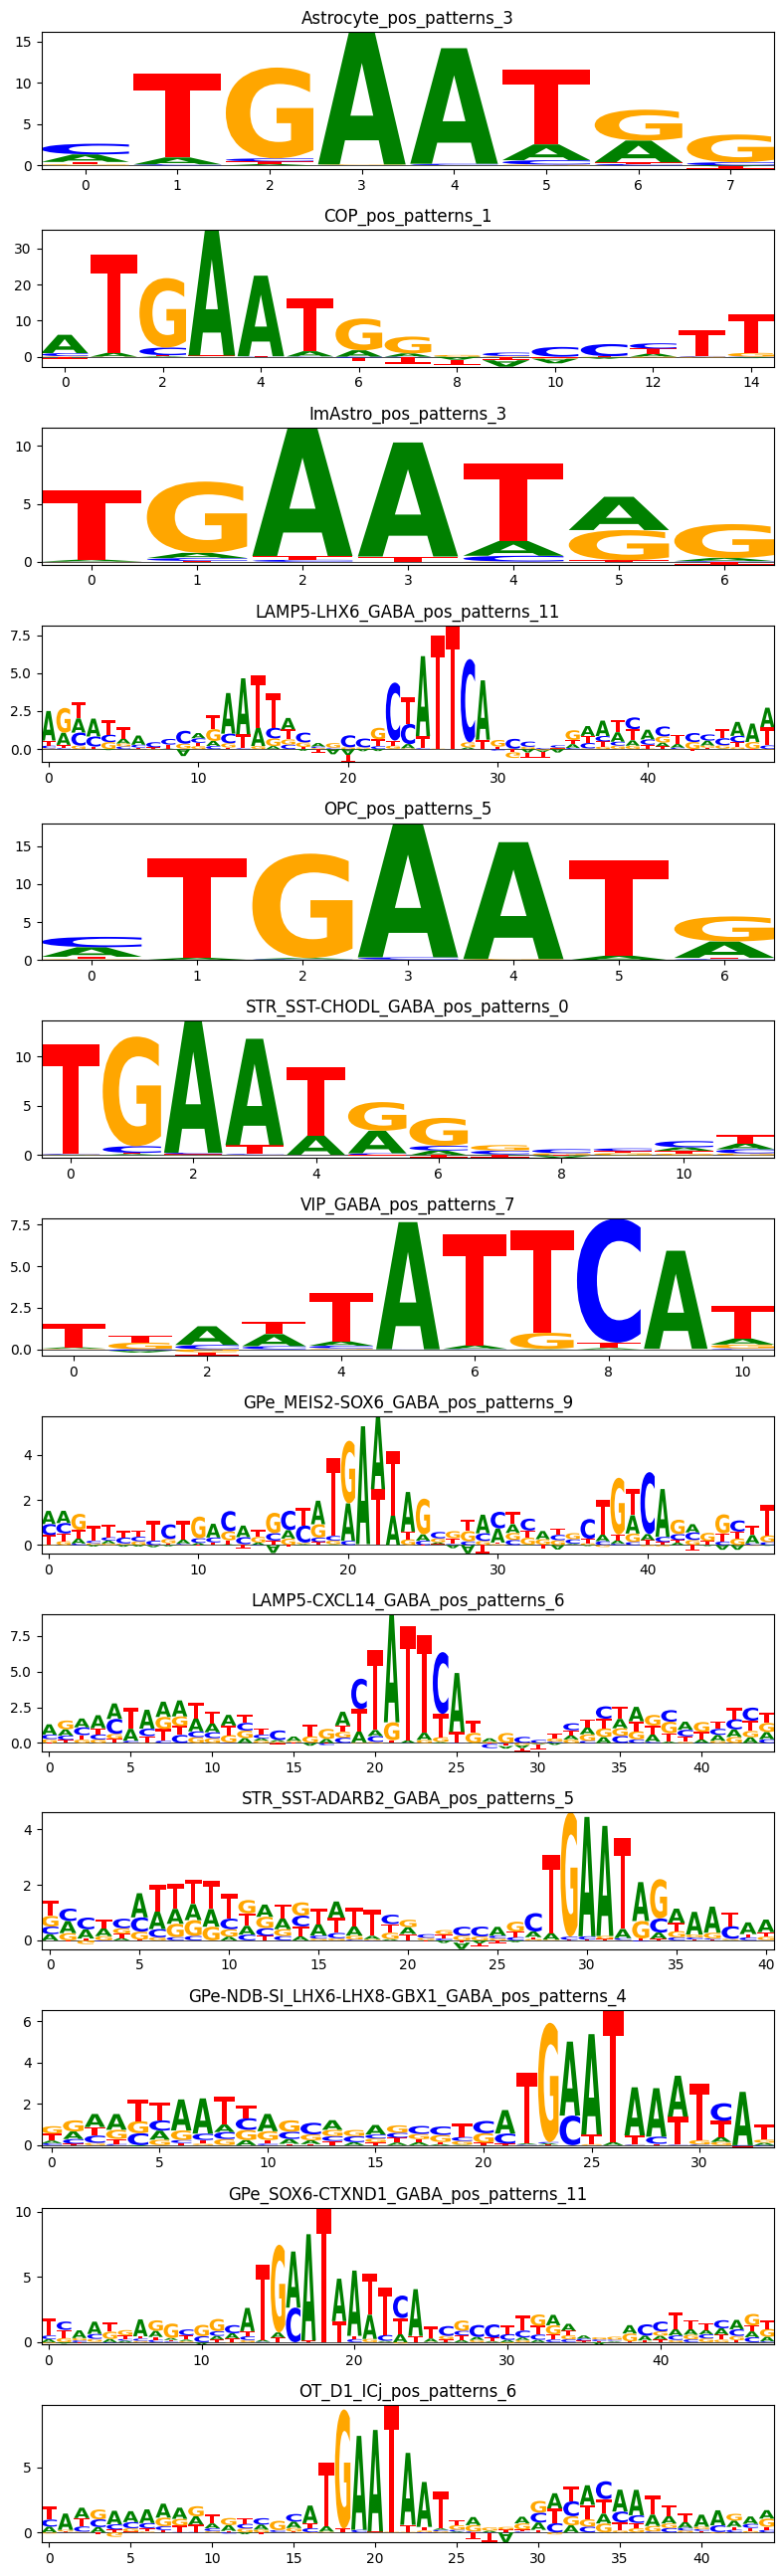

In [12]:
crested.pl.patterns.class_instances(all_patterns, 1,class_representative=True)

## TF matching

In [13]:
import crested
import anndata

file_path = (
    "/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/s3/AIT/Human_HMBA_basalganglia_AIT_pre-print.h5ad"  # Locate h5 file containing scRNAseq data
)

adata_rna = anndata.read_h5ad(file_path)

In [14]:
cell_type_column = "Group"
mean_expression_df = crested.tl.modisco.calculate_mean_expression_per_cell_type(
    file_path, cell_type_column, cpm_normalize=False
)

/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/crested/tl/modisco/_tfmodisco.py:1633: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expression_per_cell_type: pd.DataFrame = gene_expression_df.groupby(


In [15]:
indices = mean_expression_df.index.values
indices = [s.replace(" ", "_") for s in indices]

list1 = indices
list2 = list(adata.obs_names)

set1 = set(list1)
set2 = set(list2)

overlap = set1 & set2
only_in_list1 = set1 - set2
only_in_list2 = set2 - set1

print("Overlap:", overlap)
print("Only in list1:", only_in_list1)
print("Only in list2:", only_in_list2)

Overlap: {'SMC', 'LAMP5-LHX6_GABA', 'SN_SOX6_Dopa', 'STR_D1D2_Hybrid_MSN', 'STRd_D2_Matrix_MSN', 'VLMC', 'STR-BF_TAC3-PLPP4-LHX8_GABA', 'STRv_D2_MSN', 'GPi_Core', 'Oligo_OPALIN', 'STR_LYPD6-RSPO2_GABA', 'GPe_SOX6-CTXND1_GABA', 'Monocyte', 'STR_SST-CHODL_GABA', 'OPC', 'OT_D1_ICj', 'SN-VTR_GAD2_Dopa', 'LAMP5-CXCL14_GABA', 'STH_PVALB-PITX2_Glut', 'STR_FS_PTHLH-PVALB_GABA', 'VTR-HTH_Glut', 'STR_TAC3-PLPP4_GABA', 'AMY-SLEA-BNST_GABA', 'BF_SKOR1_Glut', 'GPe-NDB-SI_LHX6-LHX8-GBX1_GABA', 'OB_Dopa-GABA', 'ImOligo', 'STRd_D2_StrioMat_Hybrid_MSN', 'STRv_D1_MSN', 'Oligo_PLEKHG1', 'SN-VTR_CALB1_Dopa', 'GPin-BF_Cholinergic_GABA', 'GPi_Shell', 'AMY-SLEA-BNST_D1_GABA', 'STRd_Cholinergic_GABA', 'Astrocyte', 'ImAstro', 'Pericyte', 'Microglia', 'SN-VTR-HTH_GATA3-TCF7L2_GABA', 'STR_SST-RSPO2_GABA', 'B_cells', 'STRd_D2_Striosome_MSN', 'T_cells', 'Ependymal', 'VIP_GABA', 'STRv_D1_NUDAP_MSN', 'BAM', 'STR_SST-ADARB2_GABA', 'STRd_D1_Striosome_MSN', 'COP', 'STR_Cholinergic_GABA', 'Endo', 'SN_SEMA5A_GABA', 'OB_F

In [30]:
mean_expression_df.index

Index(['AMY-SLEA-BNST_D1_GABA', 'AMY-SLEA-BNST_GABA', 'Astrocyte', 'BAM',
       'BF_SKOR1_Glut', 'B_cells', 'COP', 'Endo', 'Ependymal',
       'GPe-NDB-SI_LHX6-LHX8-GBX1_GABA', 'GPe_MEIS2-SOX6_GABA',
       'GPe_SOX6-CTXND1_GABA', 'GPi_Core', 'GPi_Shell',
       'GPin-BF_Cholinergic_GABA', 'ImAstro', 'ImOligo', 'LAMP5-CXCL14_GABA',
       'LAMP5-LHX6_GABA', 'Microglia', 'Monocyte', 'OB_Dopa-GABA',
       'OB_FRMD7_GABA', 'OPC', 'OT_D1_ICj', 'Oligo_OPALIN', 'Oligo_PLEKHG1',
       'Pericyte', 'SMC', 'SN-VTR-HTH_GATA3-TCF7L2_GABA', 'SN-VTR_CALB1_Dopa',
       'SN-VTR_GAD2_Dopa', 'SN_EBF2_GABA', 'SN_SEMA5A_GABA', 'SN_SOX6_Dopa',
       'STH_PVALB-PITX2_Glut', 'STR-BF_TAC3-PLPP4-LHX8_GABA',
       'STR_Cholinergic_GABA', 'STR_D1D2_Hybrid_MSN',
       'STR_FS_PTHLH-PVALB_GABA', 'STR_LYPD6-RSPO2_GABA',
       'STR_SST-ADARB2_GABA', 'STR_SST-CHODL_GABA', 'STR_SST-RSPO2_GABA',
       'STR_TAC3-PLPP4_GABA', 'STRd_Cholinergic_GABA', 'STRd_D1_Matrix_MSN',
       'STRd_D1_Striosome_MSN', 'STRd_D2

In [16]:
mean_expression_df.index = indices

In [17]:
mean_expression_df = mean_expression_df.loc[list(adata.obs_names)]

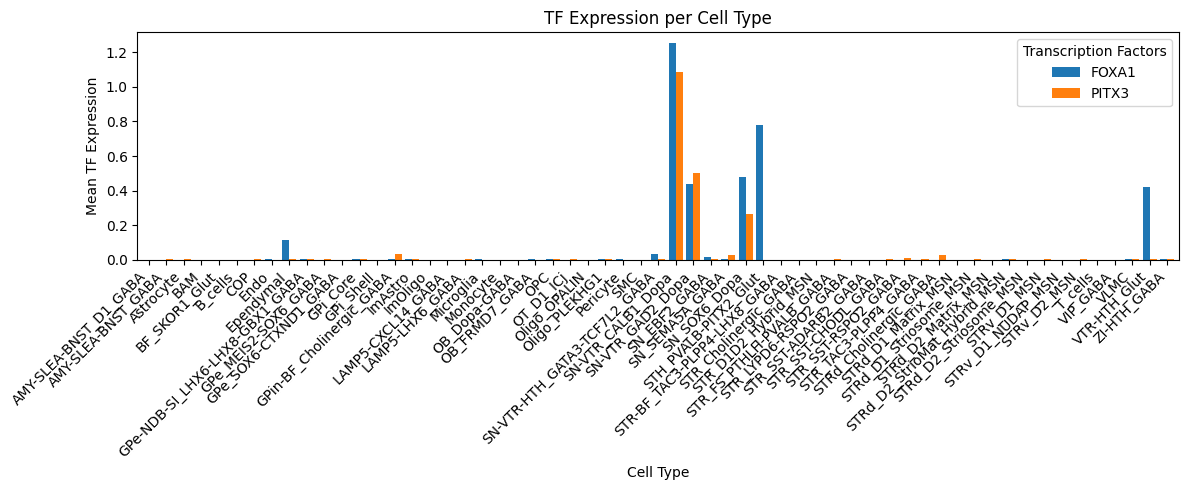

In [18]:
crested.pl.patterns.tf_expression_per_cell_type(
    mean_expression_df, ["FOXA1", "PITX3"]
)

In [31]:
classes = list(adata.obs_names)

contribution_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/patterns/modisco_results_ft_500/"
html_paths = crested.tl.modisco.generate_html_paths(
    all_patterns, classes, contribution_dir
)

pattern_match_dict = crested.tl.modisco.find_pattern_matches(
    all_patterns, html_paths, q_val_thr=0.05
)  # q_val threshold to only select significant matches

In [32]:
meme_db, motif_to_tf_file = crested.get_motif_db()
motif_to_tf_df = crested.tl.modisco.read_motif_to_tf_file(
   motif_to_tf_file
)

In [33]:
cols = [
    "Mouse_Direct_annot",
    "Mouse_Orthology_annot",
    "Cluster_Mouse_Direct_annot",
    "Cluster_Mouse_Orthology_annot",
]
cols = [
    "Human_Direct_annot",
    "Human_Orthology_annot",
    "Cluster_Human_Direct_annot",
    "Cluster_Human_Orthology_annot",
]
pattern_tf_dict, all_tfs = crested.tl.modisco.create_pattern_tf_dict(
    pattern_match_dict, motif_to_tf_df, all_patterns, cols
)
tf_ct_matrix, tf_pattern_annots = crested.tl.modisco.create_tf_ct_matrix(
    pattern_tf_dict,
    all_patterns,
    mean_expression_df,
    classes,
    log_transform=False,
    normalize_pattern_importances=False,
    normalize_gex=True,
    min_tf_gex=0.95,
    importance_threshold=4,
    pattern_parameter="seqlet_count_log",
    filter_correlation=True,
    verbose=True,
    zscore_threshold=1.5,
    correlation_threshold=0.5,
)

Total columns before threshold filtering: 2618
Total columns after threshold filtering: 385
Total columns removed: 2233
Total columns before correlation filtering: 385
Total columns after correlation filtering: 83
Total columns removed: 302


/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/crested/pl/patterns/_modisco_results.py:1125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


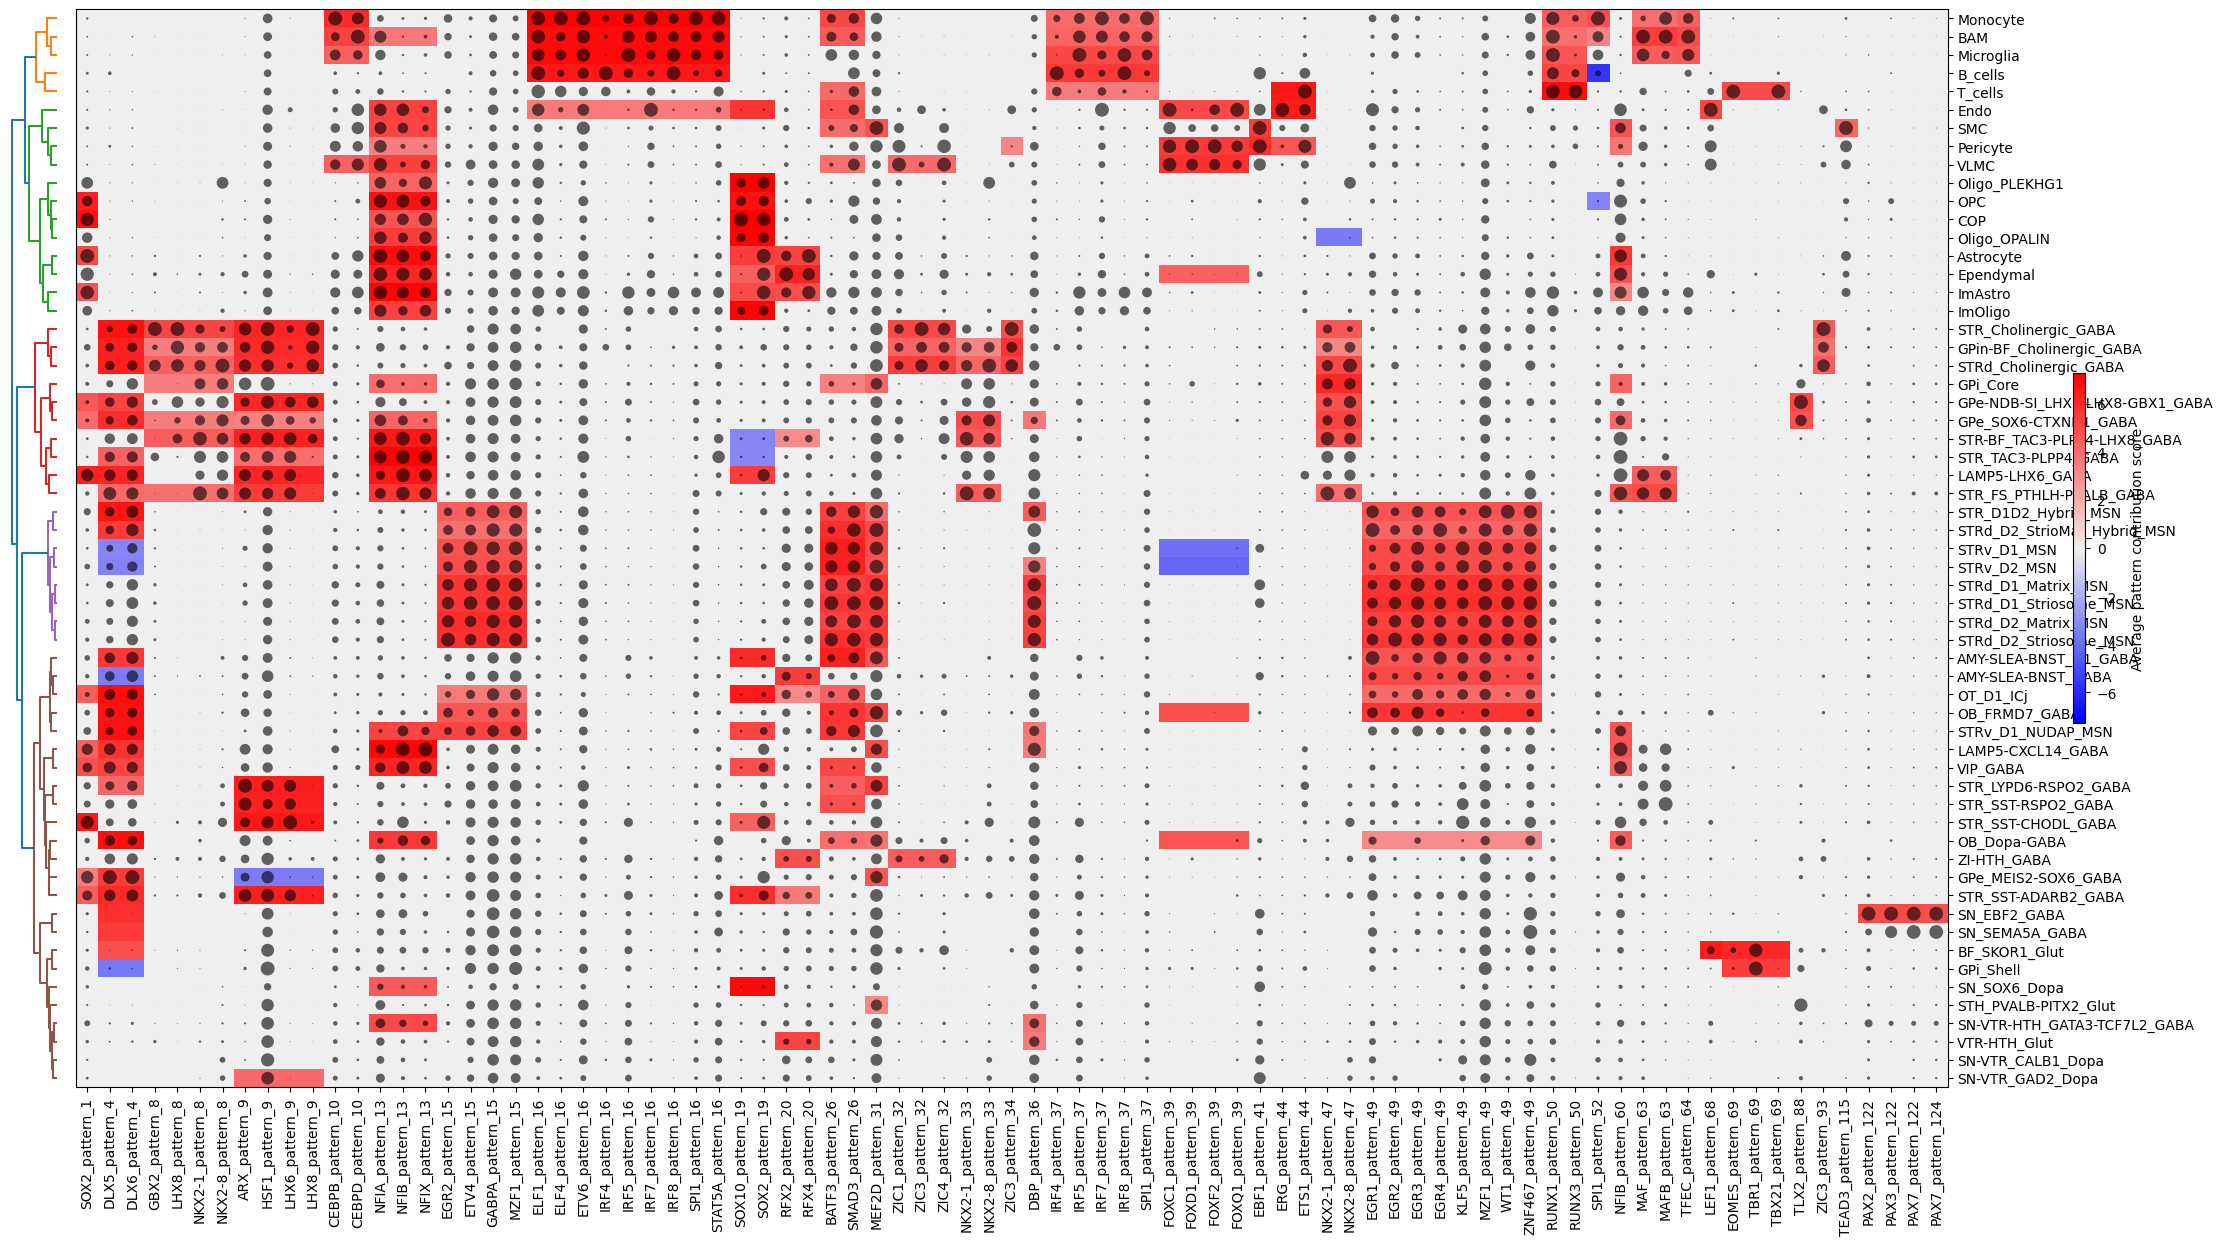

In [34]:
crested.pl.patterns.clustermap_tf_motif(
    tf_ct_matrix,
    heatmap_dim="contrib",
    dot_dim="gex",
    class_labels=classes,
    pattern_labels=tf_pattern_annots,
    fig_size=(25, 14),
    cluster_rows=True,
    cluster_columns=False,
)

## Extract pwms

In [52]:
all_patterns['0']['pattern'].keys()

dict_keys(['sequence', 'contrib_scores', 'hypothetical_contribs', 'seqlets', 'file_path', 'id', 'pos_pattern', 'n_seqlets', 'ic', 'ppm', 'class'])

In [54]:
pattern_to_ppm = {}
for pat_id in all_patterns.keys():
    ppm = all_patterns[pat_id]['pattern']['ppm']
    pattern_to_ppm[pat_id] = ppm

In [59]:
import pickle
with open("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/macaque/patterns/patterns_to_ppm.pkl", "wb") as f:
    pickle.dump(pattern_to_ppm, f)

In [ ]:
pattern_to_ppm

In [66]:
per_group_ppms = {}

import os

directory = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/macaque/patterns/modisco_results_ft_500/"
files = sorted([f for f in os.listdir(directory) if 'modisco' in f])

for file in files:
    ct = file.split('_modisco_results')[0]
    ppms = crested.tl.modisco.get_pwms_from_modisco_file(directory+file)
    per_group_ppms[ct] = ppms

In [69]:
import pickle
with open("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/macaque/patterns/per_group_ppms.pkl", "wb") as f:
    pickle.dump(per_group_ppms, f)